In [ ]:
# SPDX-License-Identifier: Apache-2.0
#
# Copyright 2024 Fujitsu Limited
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## User guide of FairDownsampling

In this tutorial we make use of the FairDownsampling algorithm.  We apply it in the Adult dataset, we compute accuracy and fairness using various common classification algorithms and we compare with the results before downsampling.  We demonstrate improvement of fairness for three common fairness metrics without sacrificing accuracy.

The algorithm FairDownsampling can be applied to a wide range of imbalanced datasets.  The imbalance appears both at the class (majority vs minority) as well as the group level (e.g. gender, age, race).  In traditional downsampling methods, such as NearMiss, there is usually a trade-off between accuracy and fairness. Downsampling would often slightly increase accuracy, but in most cases fairness deteriorates significantly. The proposed downsampling algorithm considers both fairness and accuracy, while trying to avoid underfitting, by deleting samples away from the class and group boundaries.

We demonstrate our algorithm using the Adult dataset.

#### imports

Necessary imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from imblearn.under_sampling import NearMiss #controlled under-sampling algorithm
from ucimlrepo import fetch_ucirepo #for downloading datasets

import aif360
from aif360 import metrics

import fairdownsampling as fd

#### Use case guide: Adult dataset

We use the common dataset Adult which can be downloaded from <br> https://archive.ics.uci.edu/dataset/2/adult<br>
We then prepare it and convert it to aif360 format.

In [ ]:
adult = fetch_ucirepo(id=2) 
# input data (as pandas dataframes) 
X_adult = adult.data.features 
y_adult = adult.data.targets
#preprocess and prepare Adult dataset
adult_total = pd.concat([X_adult, y_adult], axis=1)
adult_total.replace({'income': {'<=50K.': '<=50K', '>50K.': '>50K'}}, inplace=True)
adult1 = adult_total.dropna()
adult2 = adult1.drop_duplicates()
for col in list(adult2.columns):
    adult2[[col]] = LabelEncoder().fit_transform(adult2[[col]].to_numpy().reshape(-1)).reshape(-1,1)
adult_final = adult2.drop(columns=['fnlwgt']).drop_duplicates()
X_adult_final = adult_final.drop(columns=['income'])
y_adult_final = adult_final['income']

#convert Adult dataset into AIF360 dataset format
dataset_adult = X_adult_final.copy()
dataset_adult["income"] = y_adult_final.copy()
aif360_adult = aif360.datasets.BinaryLabelDataset(
    df=dataset_adult,
    label_names=["income"],
    favorable_label=1.0,
    unfavorable_label=0.0,
    protected_attribute_names=["sex"],
    unprivileged_protected_attributes=[np.array([0.0])],
    privileged_protected_attributes=[np.array([1.0])])

In [6]:
#take a look at the dataset
adult_final

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,22,7,9,12,4,1,1,4,1,27,0,39,39,0
1,33,6,9,12,2,4,0,4,1,0,0,12,39,0
2,21,4,11,8,0,6,1,4,1,0,0,39,39,0
3,36,4,1,6,2,6,0,2,1,0,0,39,39,0
4,11,4,9,12,2,10,5,2,0,0,0,39,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48835,31,2,12,13,0,8,1,4,1,0,0,39,39,0
48836,16,4,9,12,4,10,3,4,1,0,0,39,39,0
48837,22,4,9,12,0,10,1,4,0,0,0,35,39,0
48840,27,4,9,12,0,1,3,1,1,82,0,39,39,0


#### Accuracy and Fairness before FairDownsampling

We calculate accuracy and fairness before downsampling for seven common classification algorithms.  We store the results in a list for later comparison.

We measure accuracy performance using the Balanced Accuracy metric, and we measure fairness using Statistical Parity Difference, Equal Opportunity Difference, and Average Odds Difference.

In [7]:
models = [LogisticRegression(max_iter=10000),
          RandomForestClassifier(),
          KNeighborsClassifier(),
          XGBClassifier(),
          GaussianNB(),
          GradientBoostingClassifier(),
          DecisionTreeClassifier()
         ]

metric_1_before = [] #balanced accuracy
metric_2_before = [] #statistical parity difference
metric_3_before = [] #equal opportunity difference
metric_4_before = [] #average odds difference
    
for model in models:
    
    metric_1_temp = []
    metric_2_temp = []
    metric_3_temp = []
    metric_4_temp = []
    
    for random_state in [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]:

        X_train, X_test, y_train, y_test = train_test_split(X_adult_final, y_adult_final, test_size=0.30, random_state=random_state)
        
        model.fit(X_train.values, y_train.values)
        y_predicted = model.predict(X_test.values)

        dataset_before = X_test.copy()
        dataset_before["Labels"] = y_test.copy()
        aif360_before = aif360.datasets.BinaryLabelDataset(
            df=dataset_before,
            label_names=["Labels"],
            protected_attribute_names=["sex"])

        dataset_after = X_test.copy()
        dataset_after["Labels"] = y_predicted.copy()
        aif360_after = aif360.datasets.BinaryLabelDataset(
            df=dataset_after,
            label_names=["Labels"],
            protected_attribute_names=["sex"])

        classification_metric = aif360.metrics.ClassificationMetric(
            dataset=aif360_before,
            classified_dataset=aif360_after,
            unprivileged_groups=[{"sex": 0}],
            privileged_groups=[{"sex": 1}])

        metric_1_temp.append(np.abs(balanced_accuracy_score(y_test, y_predicted)))
        metric_2_temp.append(-(classification_metric.statistical_parity_difference()))
        metric_3_temp.append(-(classification_metric.equal_opportunity_difference()))
        metric_4_temp.append(-(classification_metric.average_odds_difference()))

    metric_1_before.append(np.mean(metric_1_temp))
    metric_2_before.append(np.mean(metric_2_temp))
    metric_3_before.append(np.mean(metric_3_temp))
    metric_4_before.append(np.mean(metric_4_temp))

#### FairDownsampling

We next perform FairDownsampling on the Adult dataset

In [8]:
model_adult = fd.FairDownSampler(sampling_strategy=0.8)
downsampled_adult = model_adult.fit_resample(aif360_adult)

#### Accuracy and Fairness after FairDownsampling

We then compute Accuracy and Fairness after FairDownsampling.  We store the results.

In [9]:
X_resampled = ((downsampled_adult.convert_to_dataframe())[0]).drop(columns=['income'])
y_resampled = ((downsampled_adult.convert_to_dataframe())[0])['income']

In [ ]:
models = [LogisticRegression(max_iter=10000),
          RandomForestClassifier(),
          KNeighborsClassifier(),
          XGBClassifier(),
          GaussianNB(),
          GradientBoostingClassifier(),
          DecisionTreeClassifier()
         ]

metric_1_after = [] #balanced accuracy
metric_2_after = [] #statistical parity difference
metric_3_after = [] #equal opportunity difference
metric_4_after = [] #average odds difference
    
for model in models:
    
    metric_1_temp = []
    metric_2_temp = []
    metric_3_temp = []
    metric_4_temp = []
    
    for random_state in [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]:

        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.30, random_state=random_state)
        
        model.fit(X_train, y_train)
        y_predicted = model.predict(X_test.values)

        dataset_before = X_test.copy()
        dataset_before["Labels"] = y_test.copy()
        aif360_before = aif360.datasets.BinaryLabelDataset(
            df=dataset_before,
            label_names=["Labels"],
            protected_attribute_names=["sex"])

        dataset_after = X_test.copy()
        dataset_after["Labels"] = y_predicted.copy()
        aif360_after = aif360.datasets.BinaryLabelDataset(
            df=dataset_after,
            label_names=["Labels"],
            protected_attribute_names=["sex"])

        classification_metric = aif360.metrics.ClassificationMetric(
            dataset=aif360_before,
            classified_dataset=aif360_after,
            unprivileged_groups=[{"sex": 0}],
            privileged_groups=[{"sex": 1}])

        metric_1_temp.append(balanced_accuracy_score(y_test, y_predicted))
        metric_2_temp.append(-classification_metric.statistical_parity_difference())
        metric_3_temp.append(-classification_metric.equal_opportunity_difference())
        metric_4_temp.append(-classification_metric.average_odds_difference())

    metric_1_after.append(np.mean(metric_1_temp))
    metric_2_after.append(np.mean(metric_2_temp))
    metric_3_after.append(np.mean(metric_3_temp))
    metric_4_after.append(np.mean(metric_4_temp))

#### Comparison before and after FairDownsampling

We want to compare our accuracy and fairness before and after downsampling.  Thus, we plot the obtained results as accuracy vs fairness for the three different fairness metrics.  The plots demonstrate improvements in fairness without sacrificing accuracy.

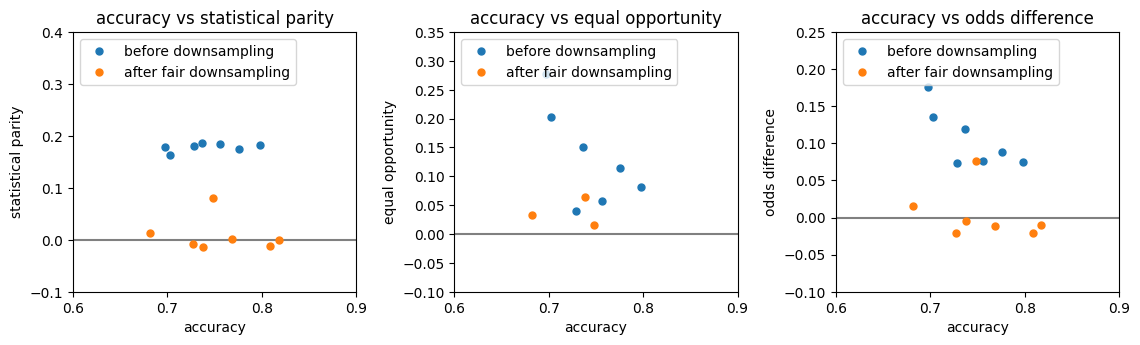

In [11]:
markersize = 5
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4));
fig.tight_layout(pad=4.0)
ax[0].set_title("accuracy vs statistical parity")
ax[0].set_xlabel("accuracy")
ax[0].set_ylabel("statistical parity")
ax[1].set_title("accuracy vs equal opportunity")
ax[1].set_xlabel("accuracy")
ax[1].set_ylabel("equal opportunity")
ax[2].set_title("accuracy vs odds difference")
ax[2].set_xlabel("accuracy")
ax[2].set_ylabel("odds difference")
x = np.linspace(0.5, 1, 100)
y = np.linspace(0, 0, 100)
ax[0].plot(x, y, linestyle='solid', c='gray')
ax[1].plot(x, y, linestyle='solid', c='gray')
ax[2].plot(x, y, linestyle='solid', c='gray')
ax[0].plot(metric_1_before, metric_2_before, 'o', label='before downsampling', markersize=markersize);
ax[1].plot(metric_1_before, metric_3_before, 'o', label='before downsampling', markersize=markersize);
ax[2].plot(metric_1_before, metric_4_before, 'o', label='before downsampling', markersize=markersize);
ax[0].plot(metric_1_after, metric_2_after, 'o', label='after fair downsampling', markersize=markersize);
ax[1].plot(metric_1_after, metric_3_after, 'o', label='after fair downsampling', markersize=markersize);
ax[2].plot(metric_1_after, metric_4_after, 'o', label='after fair downsampling', markersize=markersize);
ax[0].set_xlim([0.6, 0.9])
ax[1].set_xlim([0.6, 0.9])
ax[2].set_xlim([0.6, 0.9])
ax[0].set_ylim([-0.1, 0.4])
ax[1].set_ylim([-0.1, 0.35])
ax[2].set_ylim([-0.1, 0.25])
ax[0].legend(loc="upper left")
ax[1].legend(loc="upper left")
ax[2].legend(loc="upper left");
plt.show()